
# Kickstarter Project Success Prediction

## Goal
Predict whether a Kickstarter project will succeed or fail based on data available at launch.
Target Accuracy: > 80%

## Dataset
We are using `kickstarter_data_with_features.csv` as it contains a rich set of features suitable for this classification task.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

%matplotlib inline



## 1. Data Loading and Cleaning


In [2]:

# Load dataset
df = pd.read_csv('kickstarter_data_with_features.csv')
print(f"Original shape: {df.shape}")

# Filter target variable
if 'state' in df.columns:
    df = df[df['state'].isin(['successful', 'failed'])].copy()
    df['target'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)
    print(f"Filtered shape: {df.shape}")
    print(df['state'].value_counts())


Original shape: (20632, 60)
Filtered shape: (17434, 61)
state
failed        11416
successful     6018
Name: count, dtype: int64


/var/folders/l0/q3shlp492gg7r8d1pc18rfjm0000gn/T/ipykernel_6948/322509747.py:2: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('kickstarter_data_with_features.csv')



## 2. Feature Selection and Engineering
We remove columns that are not available at launch (data leakage) or are not useful for prediction.


In [3]:

# Define leakage and metadata columns to drop
leakage_keywords = ['pledged', 'backers', 'staff_pick', 'spotlight', 'state_changed', 
                    'launch_to_state', 'disable_communication', 'is_backing', 'is_starred', 'permissions']

cols_to_drop = []
for col in df.columns:
    if any(keyword in col for keyword in leakage_keywords):
        cols_to_drop.append(col)

# Explicit drops
explicit_drop = ['state', 'id', 'name', 'blurb', 'slug', 'creator', 'profile', 
                 'photo', 'urls', 'source_url', 'friends', 'currency_symbol', 'currency_trailing_code']
cols_to_drop.extend([c for c in explicit_drop if c in df.columns])

print(f"Dropping {len(cols_to_drop)} columns...")
df = df.drop(columns=cols_to_drop)


Dropping 29 columns...


In [4]:

# Date processing
date_cols = ['launched_at', 'deadline', 'created_at']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        if col == 'launched_at':
            df['launch_month'] = df[col].dt.month
            df['launch_hour'] = df[col].dt.hour
            df['launch_day'] = df[col].dt.dayofweek

# Duration feature
if 'deadline' in df.columns and 'launched_at' in df.columns:
    df['duration_days'] = (df['deadline'] - df['launched_at']).dt.total_seconds() / (3600*24)

# Drop original date columns
df = df.drop(columns=[c for c in date_cols if c in df.columns])


In [5]:

# Handle Categorical Variables
# We use Label Encoding for high-cardinality categorical features like 'category' (JSON string) and 'location'
object_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical columns: {object_cols.tolist()}")

for col in object_cols:
    if len(df[col].unique()) < 5000: # Reasonable limit
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    else:
        print(f"Dropping {col} due to high cardinality")
        df = df.drop(columns=[col])

# Fill missing values
df = df.fillna(0)


Categorical columns: ['country', 'currency', 'location', 'category', 'deadline_weekday', 'created_at_weekday', 'launched_at_weekday', 'create_to_launch', 'launch_to_deadline']
Dropping create_to_launch due to high cardinality



## 3. Model Training
We use a Random Forest Classifier.


In [6]:

X = df.drop(columns=['target'])
y = df['target']

print(f"Final features: {X.columns.tolist()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Final features: ['Unnamed: 0', 'goal', 'country', 'currency', 'static_usd_rate', 'location', 'category', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'deadline_weekday', 'created_at_weekday', 'launched_at_weekday', 'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_yr', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_yr', 'launched_at_hr', 'launch_to_deadline', 'launch_month', 'launch_hour', 'launch_day', 'duration_days']


Accuracy: 0.8689

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2310
           1       0.85      0.74      0.79      1177

    accuracy                           0.87      3487
   macro avg       0.86      0.84      0.85      3487
weighted avg       0.87      0.87      0.87      3487



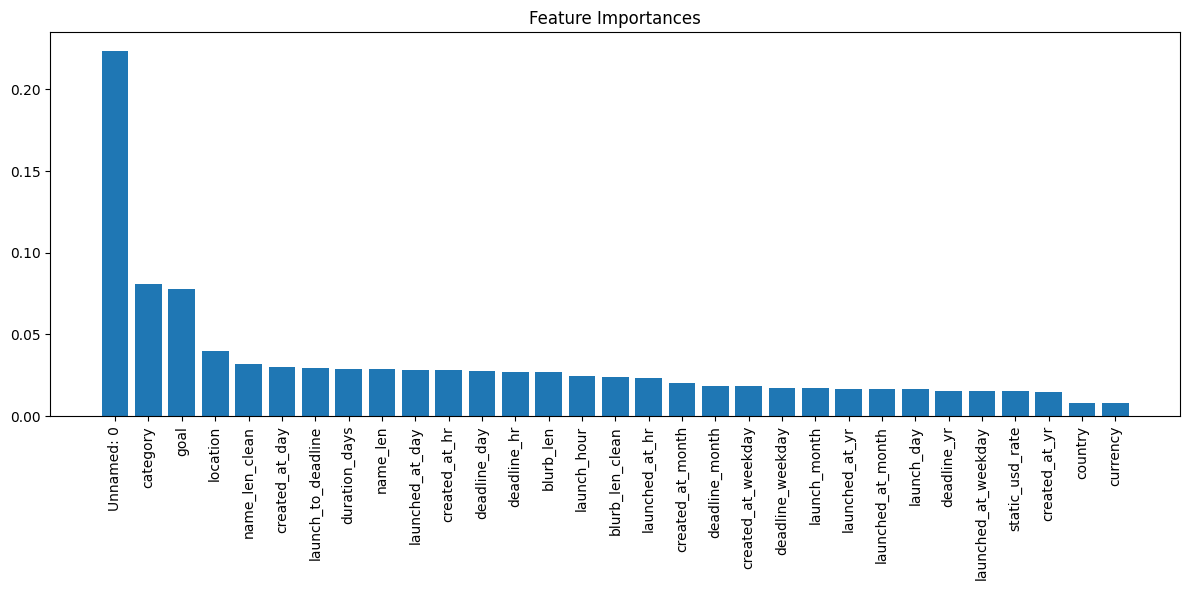

In [7]:

# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()
